In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from portfolio import Portfolio
from backtest import fine_tuning_k_means, backtest_fun, plot_results_backtest

# Build Class and function

## Collect and Download Data

In [2]:
data_csv = pd.read_csv('data/SandP500.csv')
data_csv.sort_values(by='Symbol', inplace = True)

### Download (If you already have dataset, you can skip it)

In [3]:
# portfolio = Portfolio(data_csv)
# portfolio.get_data_yahoo(save = True, path = "data\\price_data.csv", no_nan = True)

### Prepare the Dataset

In [4]:
price_data =  pd.read_csv('data/price_data.csv', index_col=0)
portfolio = Portfolio(data_csv, price_data = price_data)
portfolio.compute_return()

,A,AA,AAPL,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WM,WMB,WMT,WY,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.076389,0.004633,-0.084310,-0.028572,-0.083889,-0.050589,-0.010416,0.000000,-0.048689,0.000000,...,-0.003597,-0.022177,-0.037418,-0.037567,0.023027,-0.019154,0.000000,-0.046511,-0.020099,-0.048423
2000-01-05,-0.062030,0.057647,0.014633,-0.001838,0.019771,0.014599,-0.015790,-0.009615,-0.062992,0.038685,...,0.003610,0.061855,-0.020408,0.052974,0.038585,0.054516,0.017287,0.051490,0.005127,-0.001184
2000-01-06,-0.038076,-0.013081,-0.086538,0.034990,0.008163,-0.027339,0.005347,0.013349,-0.060924,-0.003725,...,-0.007194,0.021360,0.010912,0.046779,-0.009288,0.051698,0.001307,-0.020619,-0.008503,0.014219
2000-01-07,0.083334,-0.002946,0.047369,0.010676,0.048583,0.028108,0.015958,0.022755,0.118568,0.014953,...,-0.039855,0.026616,0.075565,-0.032884,0.000000,-0.002935,-0.002611,0.023685,-0.022298,0.002336
2000-01-10,0.060577,-0.002954,-0.017588,-0.007042,0.038610,0.087050,0.000000,0.024590,-0.010099,-0.007366,...,0.003774,-0.018518,-0.018248,-0.004359,0.000000,-0.013981,0.023560,-0.023137,0.040350,-0.018066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.000669,0.019556,0.003065,0.000700,-0.000962,0.014685,-0.001585,0.000442,-0.002113,0.004480,...,-0.009862,0.010469,-0.020490,0.021091,0.004748,0.004062,0.013369,0.126341,0.011333,0.013229
2024-12-24,0.011144,0.000778,0.011478,0.003937,0.002686,0.014891,0.004364,0.007853,0.012572,0.013379,...,0.007753,0.010176,0.025789,0.006410,0.007236,0.000941,-0.002639,-0.023281,0.008516,0.010850
2024-12-26,-0.001984,-0.006734,0.003176,0.004444,0.004956,-0.000138,-0.000395,0.002597,-0.003154,-0.002200,...,-0.001753,-0.011722,0.001187,-0.003185,-0.000440,0.000846,0.013757,-0.006500,0.007407,0.006913


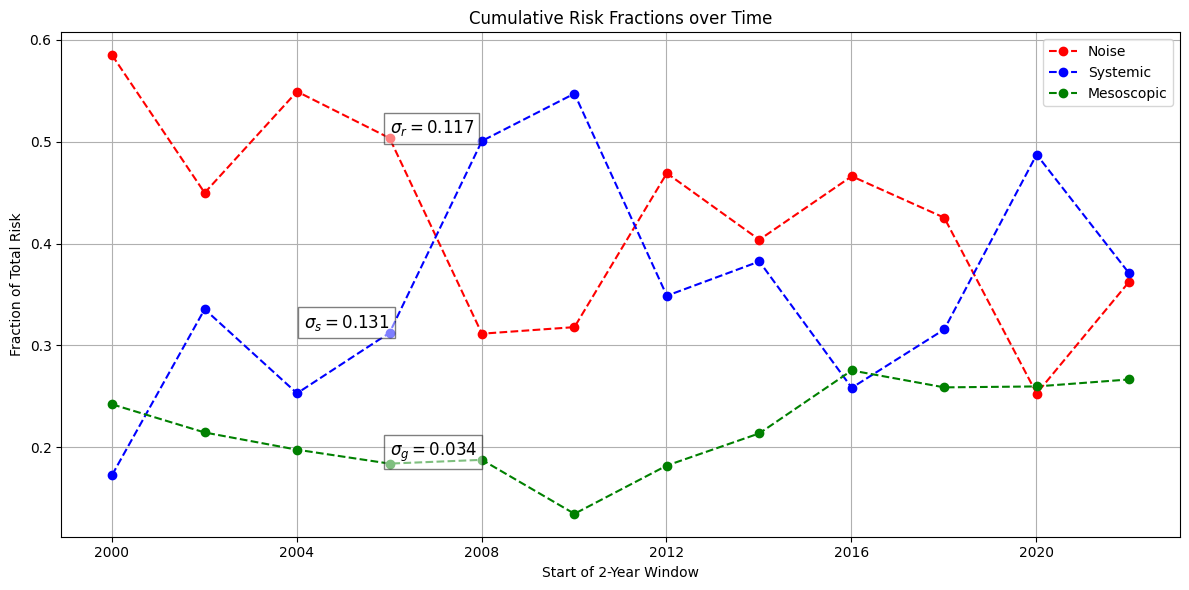

In [5]:
portfolio.plot_stability()

## Community

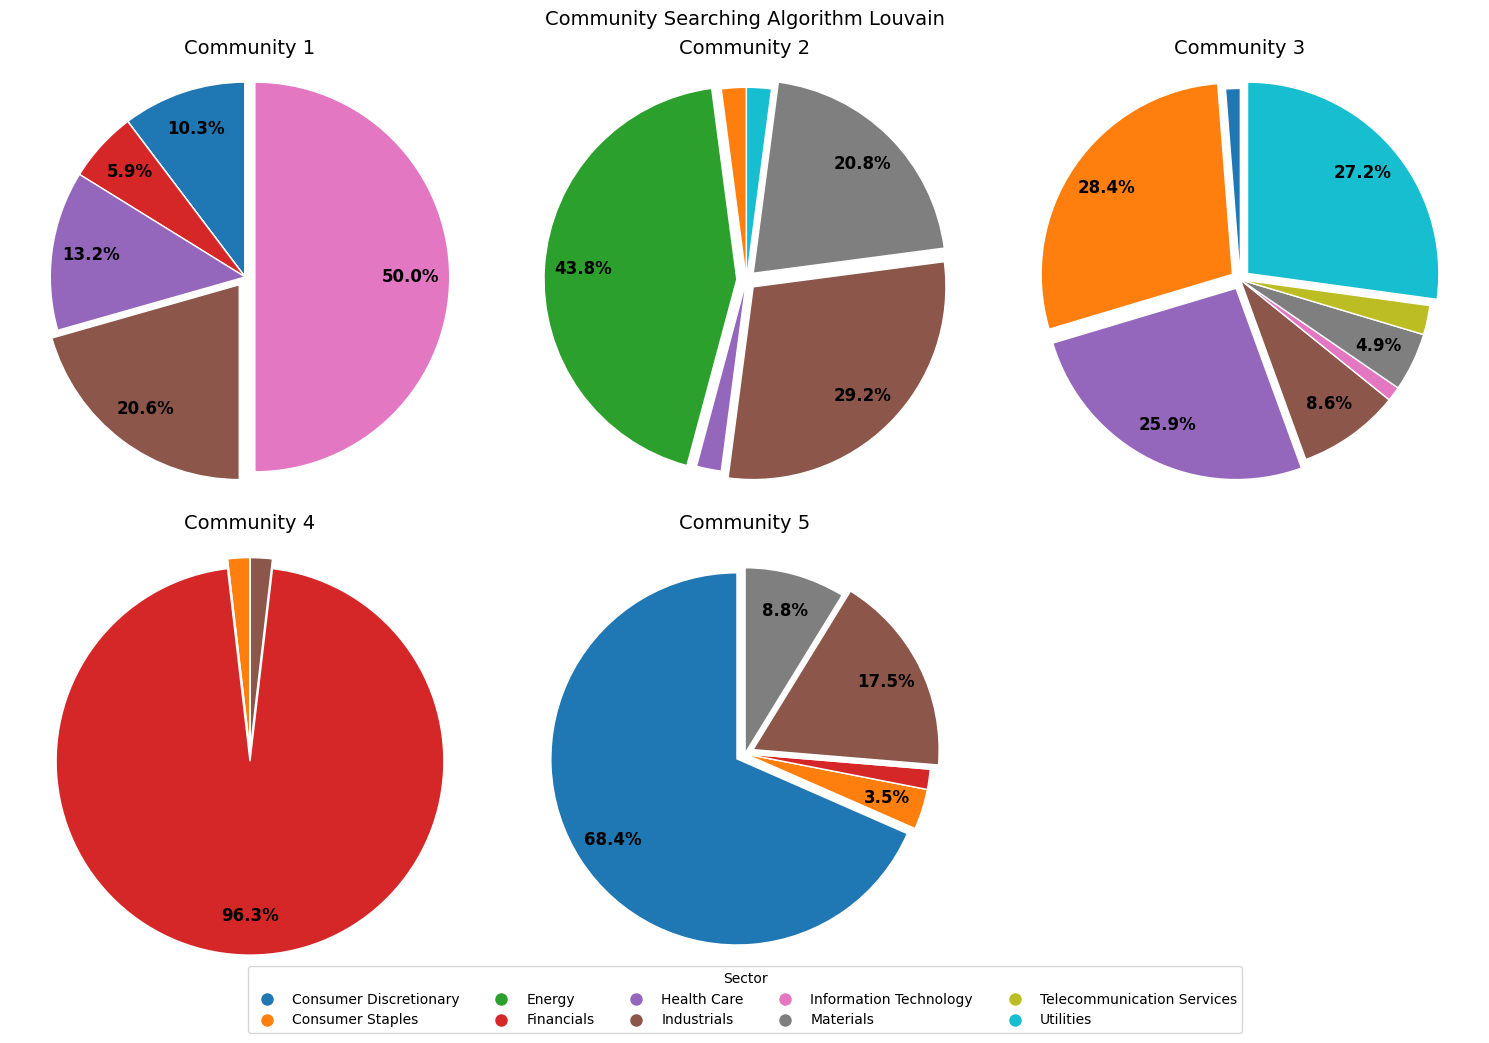

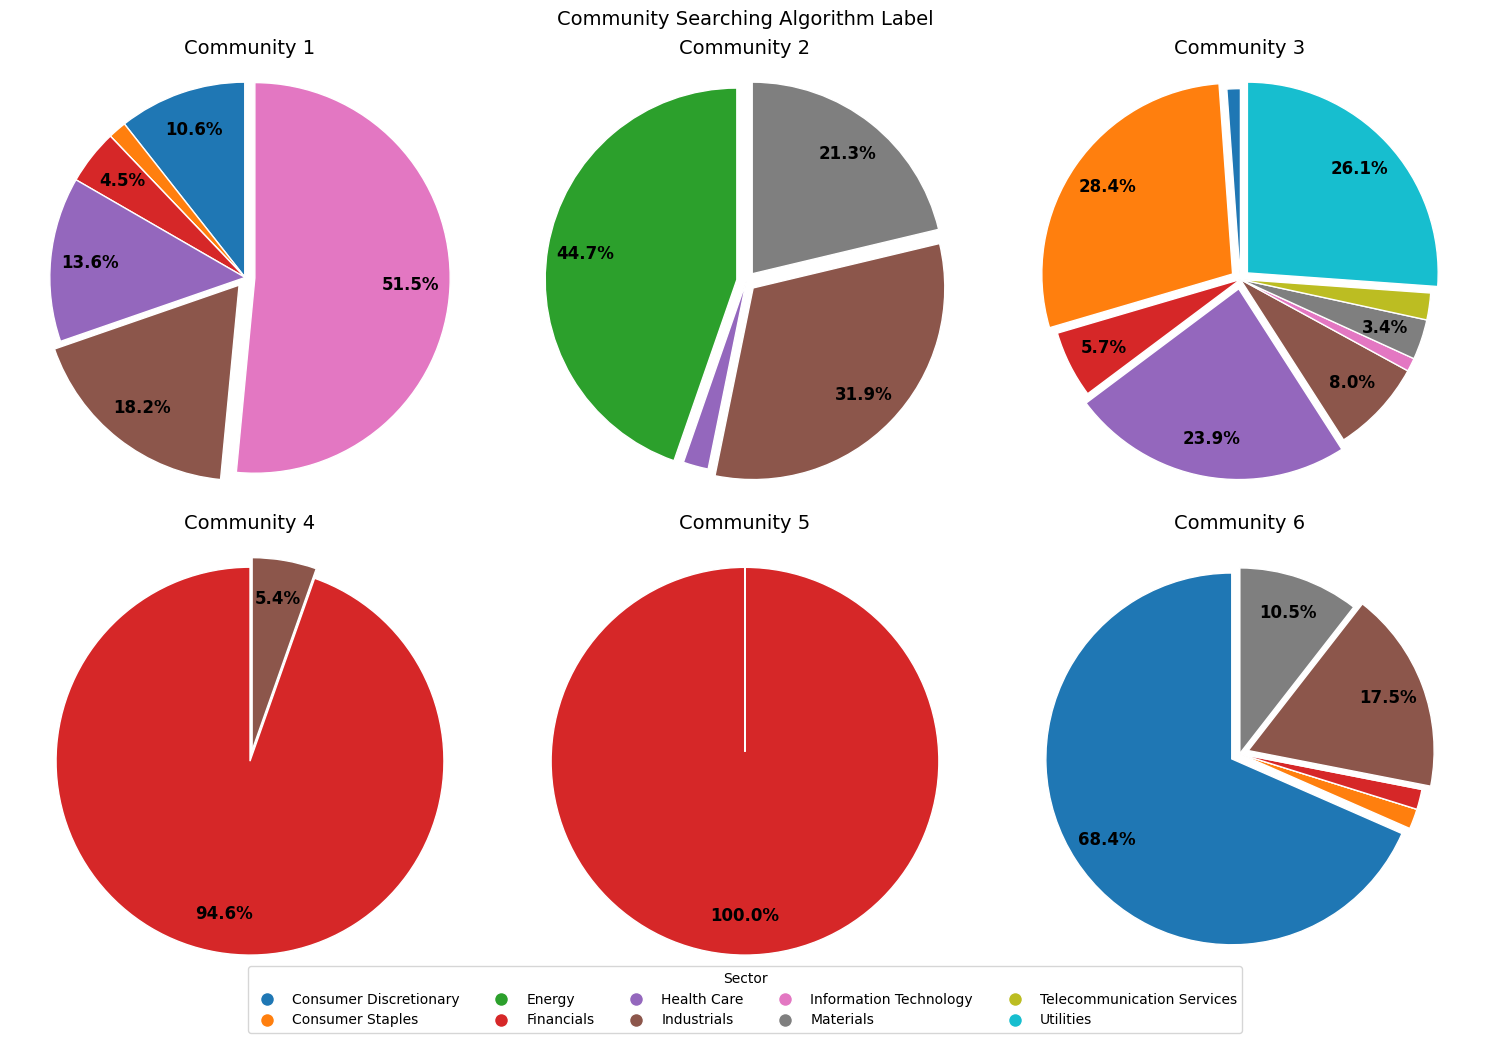

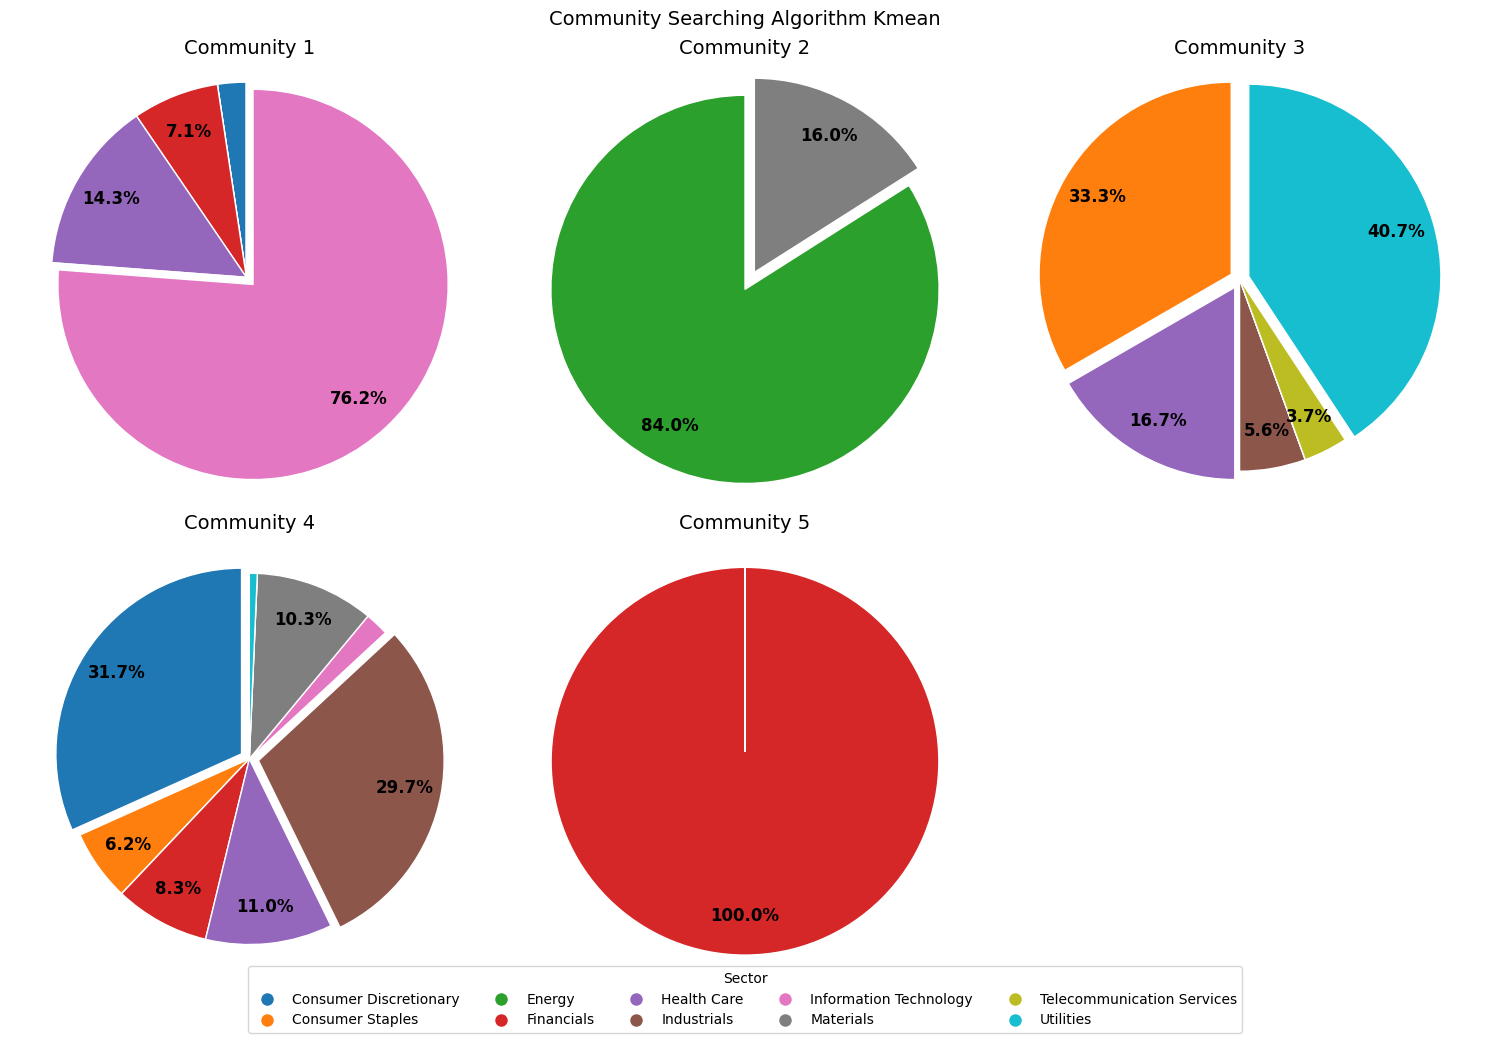

In [6]:
for i in ('Louvain', 'Label', 'Kmean'):
    portfolio.mesoscopic_filter()
    portfolio.community_discover(algo = i)
    portfolio.plot_communities_pie(title = i)
    plt.show()

## Portfolio Building

### Weight Distribution asset

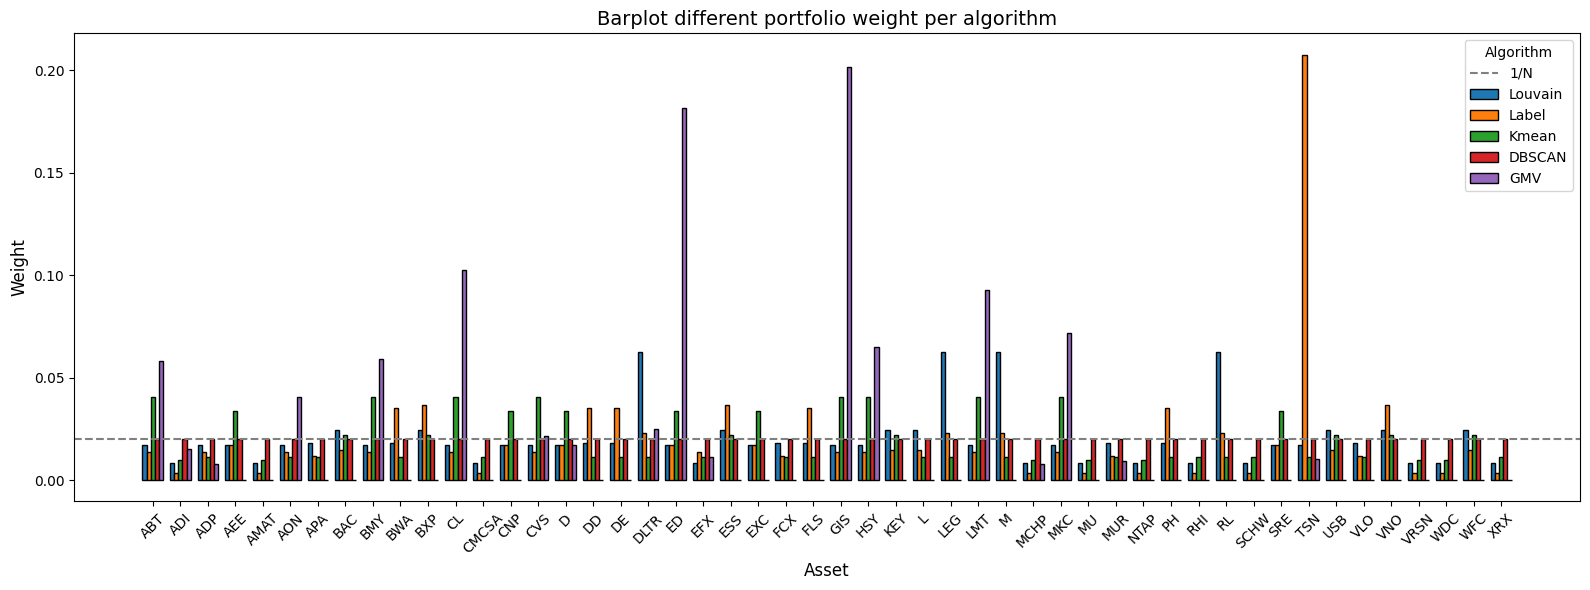

In [7]:
# create portfolio class
num_asset = 50
price_data_sampled = price_data.sample(n= num_asset, axis=1, random_state=42)
price_data_sampled = price_data_sampled[sorted(price_data_sampled.columns)]
returns = price_data_sampled.pct_change().dropna() 
portfolio = Portfolio(data_csv, price_data = price_data_sampled, returns = returns)
portfolio.C_g = portfolio.mesoscopic_filter()
weights_dict = {}

# Find weights of each portfolio
#alg_list = ["Louvain", "Label", "Kmean", "DBSCAN", "GMV"]
alg_list = ["Louvain", "Label", "Kmean", "DBSCAN"]
for alg in alg_list: 
    communities = portfolio.community_discover(algo=alg)
    weights = portfolio.portfolio_building(community=True, algo=alg)
    weights_dict[alg] = weights
weights_dict['GMV'] = portfolio.portfolio_building(community=False)
weights_df = pd.DataFrame(weights_dict, index=price_data_sampled.columns)

# Plot
labels = weights_df.index.to_list()           
algorithms = weights_df.columns.to_list()     
n_algos = len(algorithms)
x = np.arange(len(labels))                    
width = 0.15                                  

fig, ax = plt.subplots(figsize=(16, 6))
for i, algo in enumerate(algorithms):
    bar_positions = x + (i - n_algos/2) * width + width/2
    ax.bar(bar_positions, weights_df[algo], width=width, label=algo, edgecolor='black')

ax.axhline(1/num_asset, color='gray', linestyle='--', linewidth=1.5, label='1/N')
ax.set_title("Barplot different portfolio weight per algorithm", fontsize=14)
ax.set_ylabel("Weight", fontsize=12)
ax.set_xlabel("Asset", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(title="Algorithm")
plt.tight_layout()
plt.show()

## Back-test

### Fine-Tuning

====== Start Louvain ======
Cluster found: 5
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.009389617244657922), 'Sharpe Ratio': np.float64(1.5800360667641191), 'Number of Cluster': 5}
Cluster found: 5
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.4691768882704945), 'Sharpe Ratio': np.float64(-0.12272316757810034), 'Number of Cluster': 5}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.19375949186172867), 'Sharpe Ratio': np.float64(0.6277783920293528), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5186434662705658), 'Sharpe Ratio': np.float64(0.8960912849893), 'Number of Cluster': 4}
Cluster found: 5
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-07

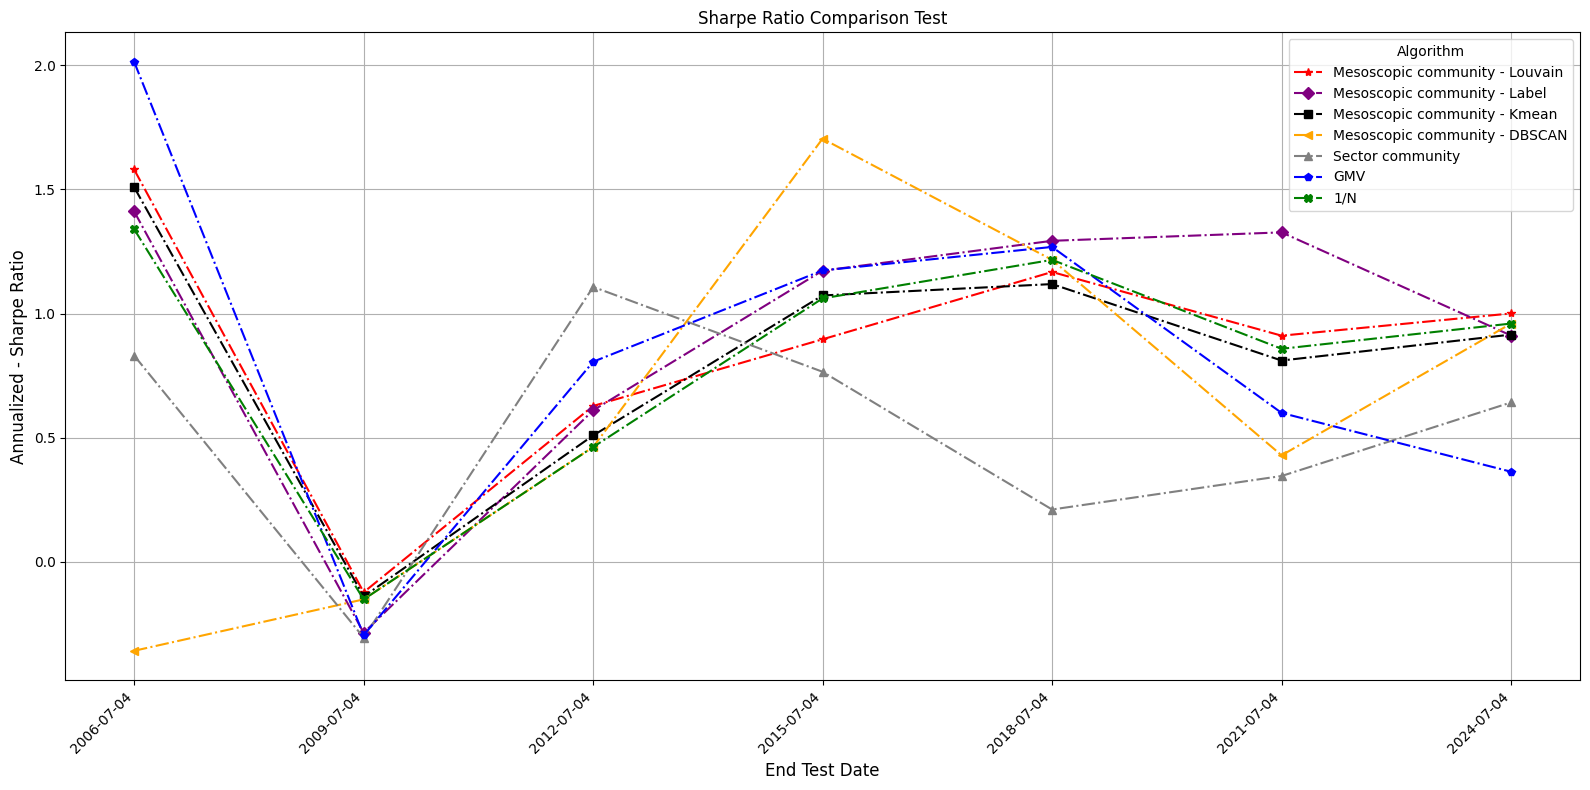

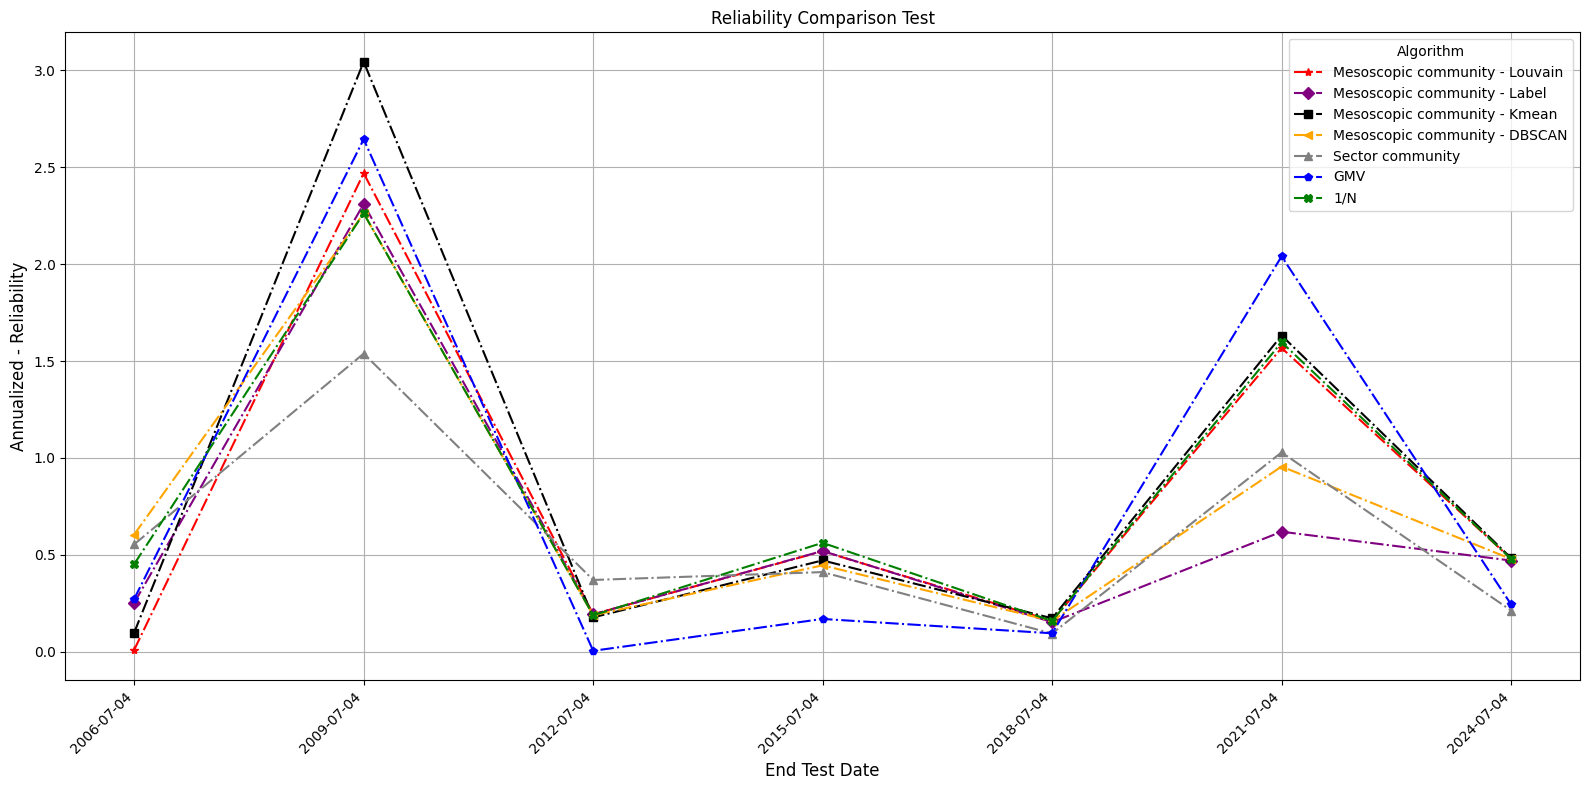

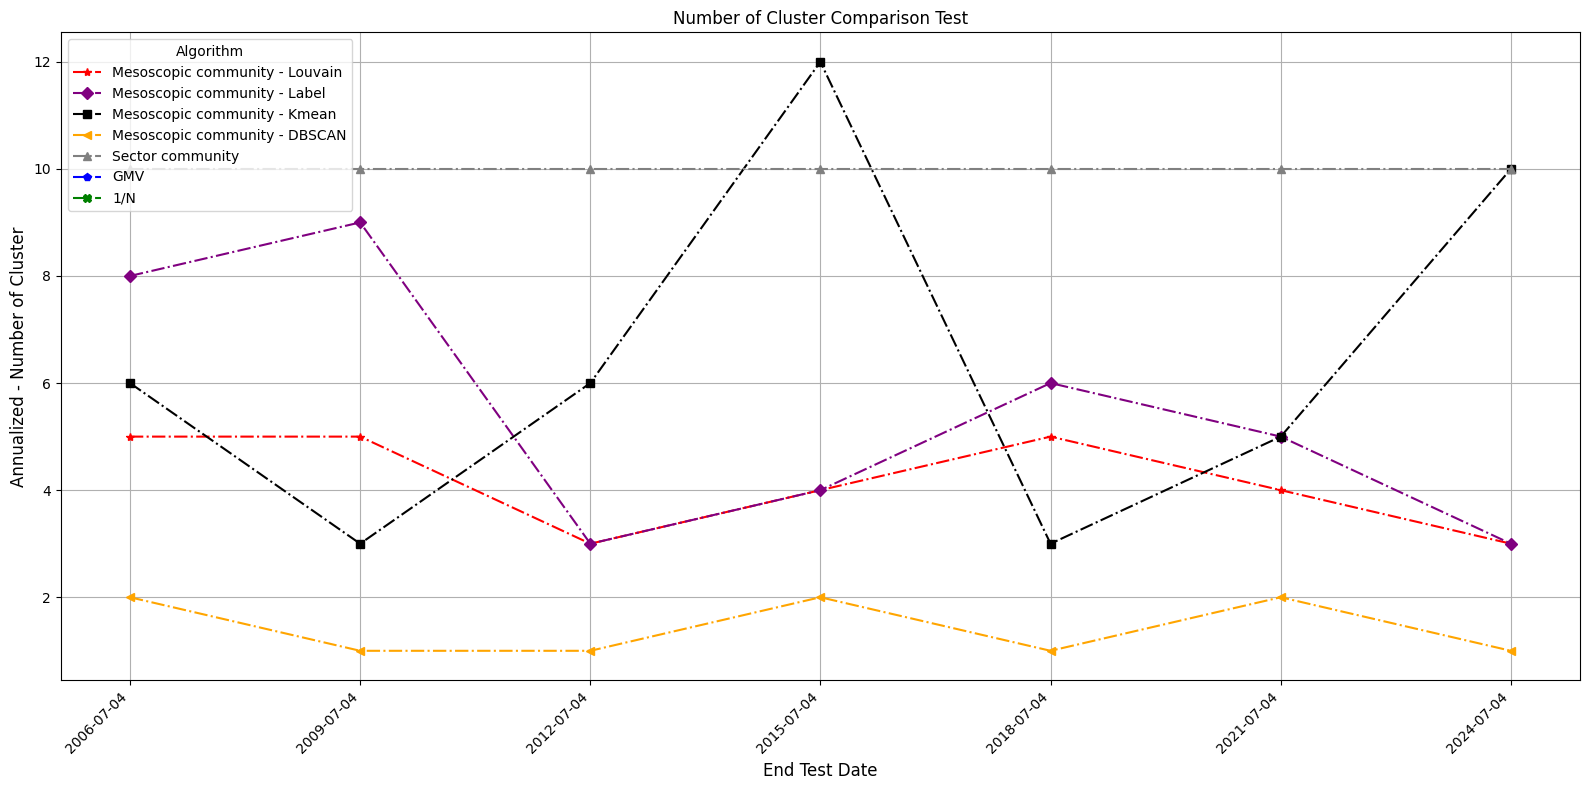

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.8656 │                0.7712 │                      4.1429 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9198 │                0.6456 │                      5.4286 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.8278 │                0.8686 │                      6.4286 │
├────┼────────────────────────────────┼─

In [8]:
model = ["Louvain", "Label","Kmean","DBSCAN", "Sector","GMV", "Equal"]
results = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = False, verbose = True, fine_tuning = True)

method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df = plot_results_backtest(results, method_labels, markers, colors)

====== Start Louvain ======
Cluster found: 5
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.009389617244657922), 'Sharpe Ratio': np.float64(1.5800360667641191), 'Number of Cluster': 5}
Cluster found: 5
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.4691768882704945), 'Sharpe Ratio': np.float64(-0.12272316757810034), 'Number of Cluster': 5}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.19375949186172867), 'Sharpe Ratio': np.float64(0.6277783920293528), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5186434662705658), 'Sharpe Ratio': np.float64(0.8960912849893), 'Number of Cluster': 4}
Cluster found: 5
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-07

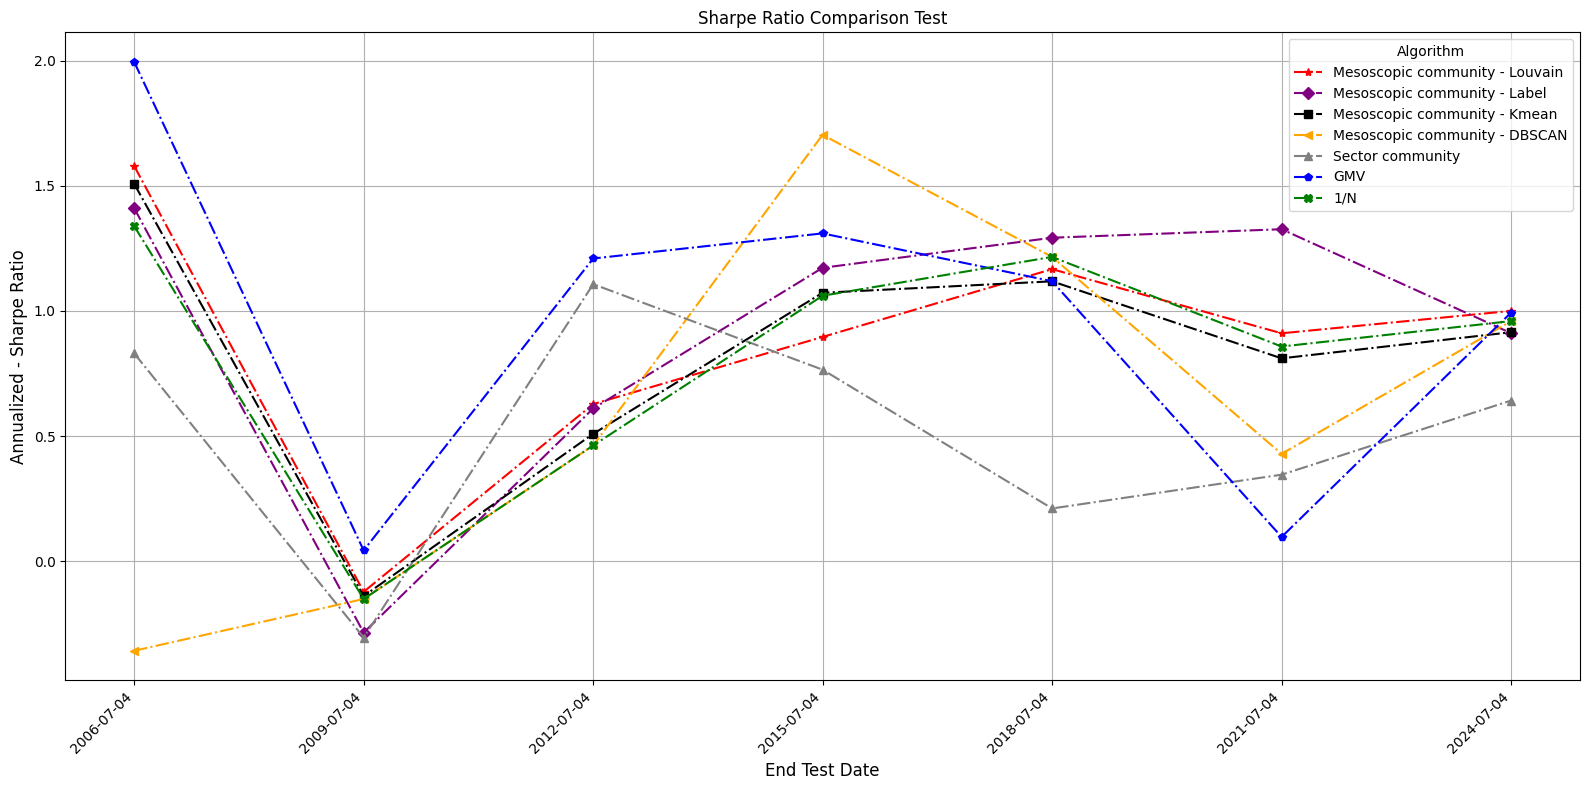

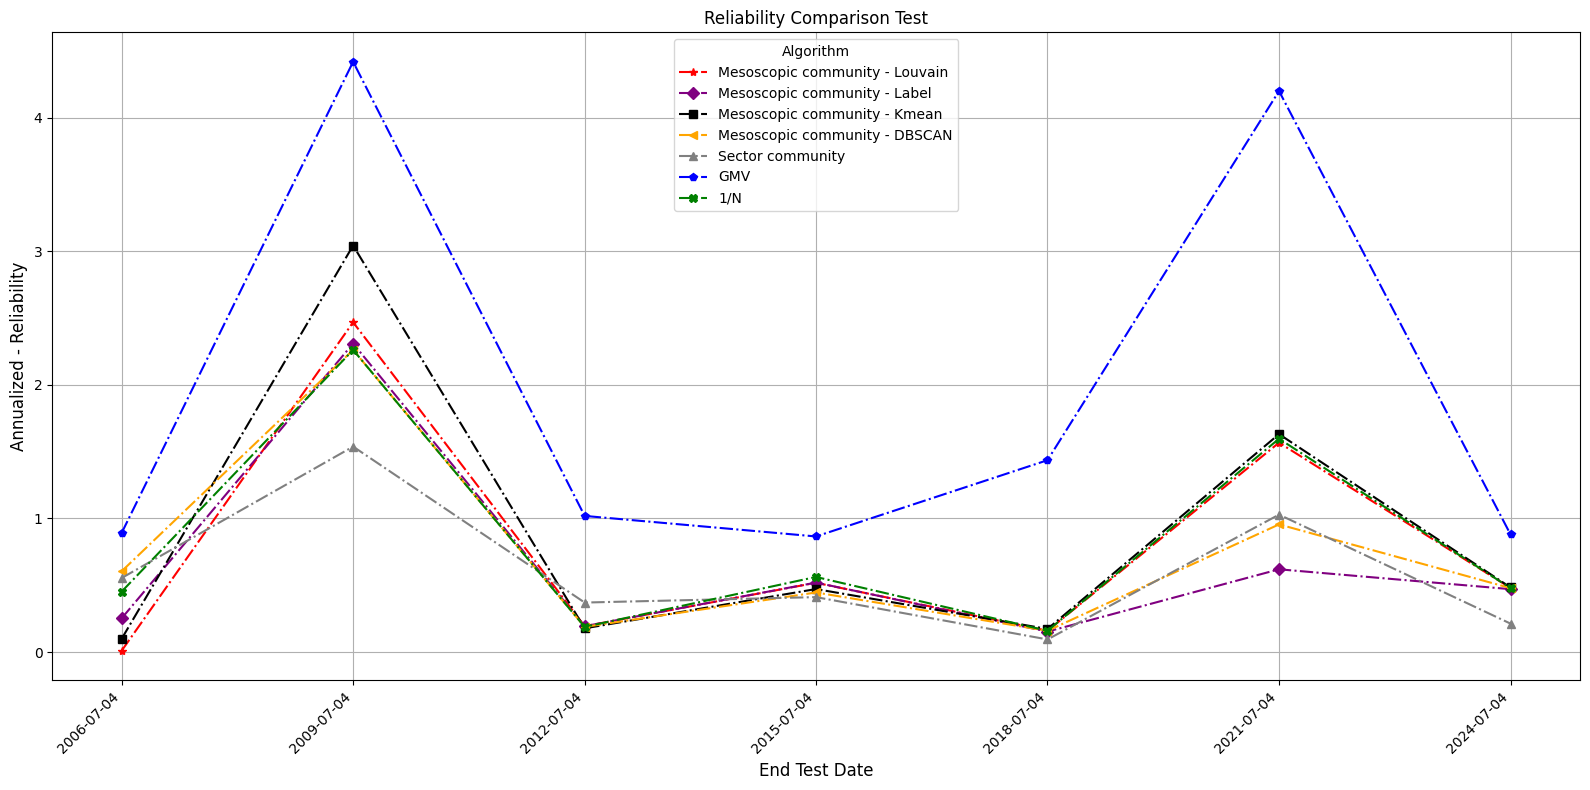

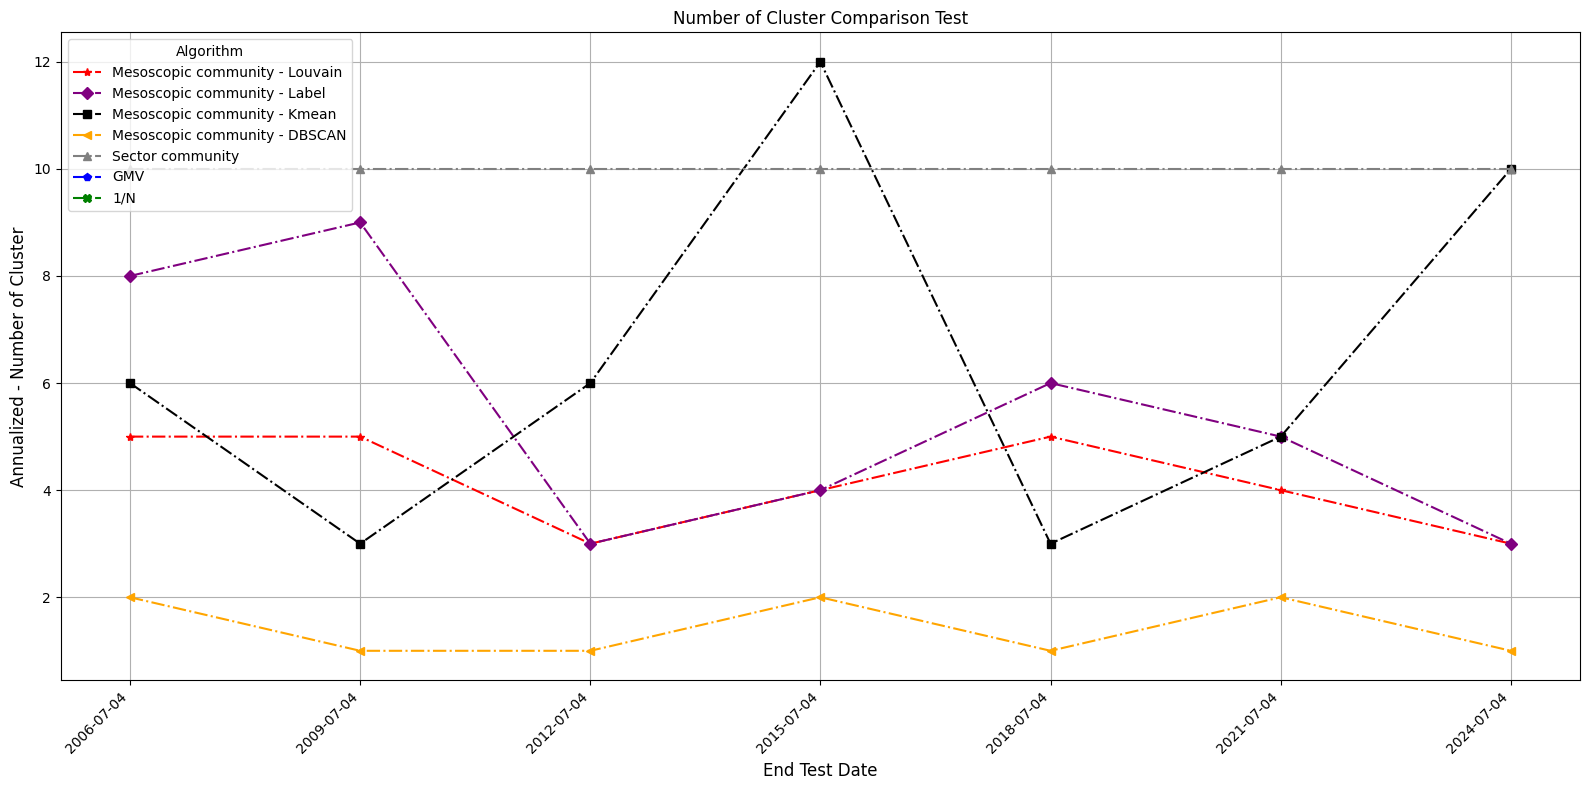

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.8656 │                0.7712 │                      4.1429 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9198 │                0.6456 │                      5.4286 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.8278 │                0.8686 │                      6.4286 │
├────┼────────────────────────────────┼─

In [9]:
model = ["Louvain", "Label", "Kmean", "DBSCAN", "Sector","GMV", "Equal"]
results_short = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results_short[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = True, verbose = True, fine_tuning = True)
method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df_short = plot_results_backtest(results_short, method_labels, markers, colors)